### Wholesale Customer Grouping using K-means and Agglomerative Hierarchical Clustering
- Conduct Data Analysis and construct Clustering models to Partition customers Keeping Similar customers into Same Group
- The purpose is to Cluster customers and Examine the Division Results

#### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,5)

#### Read Data
- read csv format file into data frame using Pandas

In [2]:
train_path = "../input/wholesale/wholesale customers data.csv"

In [3]:
train = pd.read_csv(train_path)
train.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


- data has label encoded categorical variables
- categorical variables can not be used for clustering at the same time with numerical variables
    - categories use different metric than eucildean distance for clustering

#### Data Transformation

In [4]:
region_map = {1:'Lisbon', 2:'Oporto', 3:'Other Region'}
channel_map = {1:'Horeca', 2:'Retail'}

train['Region'] = train['Region'].apply(lambda x: region_map[x])
train['Channel'] = train['Channel'].apply(lambda x: channel_map[x])

- transform categories from number to string for ease of column separation and interpretability

#### Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Channel           440 non-null    object
 1   Region            440 non-null    object
 2   Fresh             440 non-null    int64 
 3   Milk              440 non-null    int64 
 4   Grocery           440 non-null    int64 
 5   Frozen            440 non-null    int64 
 6   Detergents_Paper  440 non-null    int64 
 7   Delicassen        440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


In [6]:
train.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


- no missing values exist in data
- data might have outliers as features have 3 rd quartile that differ from upper bound a lot

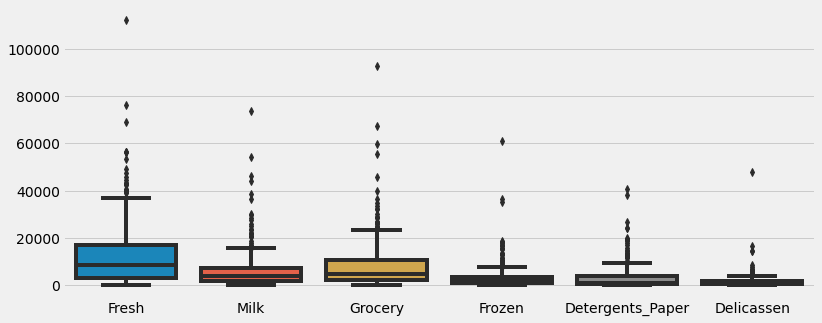

In [7]:
sns.boxplot(data=train)
plt.show()

In [8]:
np.round(pd.crosstab(train['Region'], train['Channel'], normalize=True), 2)

Channel,Horeca,Retail
Region,,
Lisbon,0.13,0.04
Oporto,0.06,0.04
Other Region,0.48,0.24


- more than 70 % of the customers are from other region
- most common customer channel is Horeca (Hotel/Restaurant/Cafe)

#### Preprocessing

In [9]:
num_cols = train.select_dtypes(exclude=['object']).columns
num_data = np.log1p(train[num_cols]) 

num_data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,8.732813,8.121615,8.442205,7.303128,6.791781,6.671094
std,1.470618,1.080635,1.111523,1.281888,1.709519,1.293960
min,1.386294,4.025352,1.386294,3.258097,1.386294,1.386294
25%,8.048378,7.335633,7.675081,6.611024,5.551989,6.014321
50%,9.048404,8.196435,8.467267,7.331043,6.706242,6.873680
75%,9.737123,8.880619,9.273948,8.176177,8.274596,7.507278
max,11.627610,11.205027,11.437997,11.016496,10.617123,10.777789


In [10]:
old_iqr = train[num_cols].quantile(0.75) - train[num_cols].quantile(0.25)
print('IQR before log transformation\n')
print(old_iqr, '\n')

new_iqr = num_data.quantile(0.75) - num_data.quantile(0.25)
print('IQR after log transformation\n')
print( new_iqr, '\n')

old_lower = train[num_cols] < train[num_cols].quantile(0.25) - 1.5 * old_iqr
new_lower = num_data < num_data.quantile(0.25) - 1.5 * new_iqr

old_upper = train[num_cols] > train[num_cols].quantile(0.75) + 1.5 * old_iqr
new_upper = num_data > num_data.quantile(0.75) + 1.5 * new_iqr

print('no. of outliers before', np.sum(old_upper.sum() + old_lower.sum()))
print('no. of outliers after', np.sum(new_upper.sum() + new_lower.sum()))

IQR before log transformation

Fresh               13806.00
Milk                 5657.25
Grocery              8502.75
Frozen               2812.00
Detergents_Paper     3665.25
Delicassen           1412.00
dtype: float64 

IQR after log transformation

Fresh               1.688745
Milk                1.544986
Grocery             1.598867
Frozen              1.565153
Detergents_Paper    2.722607
Delicassen          1.492956
dtype: float64 

no. of outliers before 172
no. of outliers after 48


- log transformation reduce overall no. of points that differ a lot from majority
- log transformation reduce chance of outliers dominating mean or position of cluster center in kmeans

In [11]:
max_abs = MaxAbsScaler()
max_abs_train = max_abs.fit_transform(num_data)

std = StandardScaler()
std_train = std.fit_transform(num_data)

- standard scaler: centers data around mean, make variance of features equal
- max abs scaler: scale features to be between 0 and 1

#### Model Building
- ##### K-means

In [12]:
def plot_inertia(data, clusters=range(1, 16)):
    inertia = []
    for k in clusters:
        kmean = KMeans(n_clusters=k, random_state=42)
        kmean.fit(data)
        inertia.append(kmean.inertia_)
    plt.figure(figsize=(10,5))
    plt.title('inertia for different no. of clusters')
    plt.xlabel('no. of clusters')
    plt.ylabel('inertia')
    plt.plot(clusters, inertia, marker='o')
    plt.show()

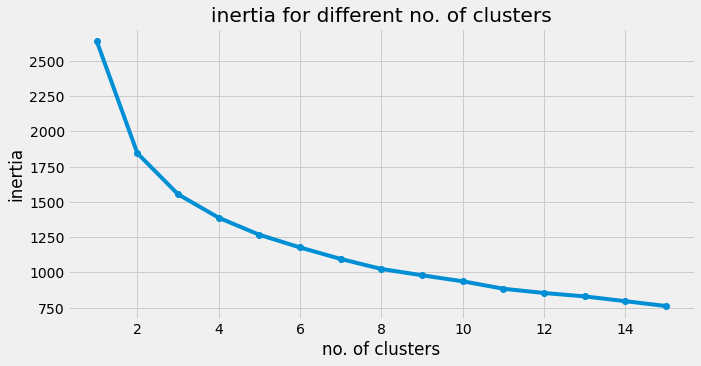

In [13]:
plot_inertia(std_train)

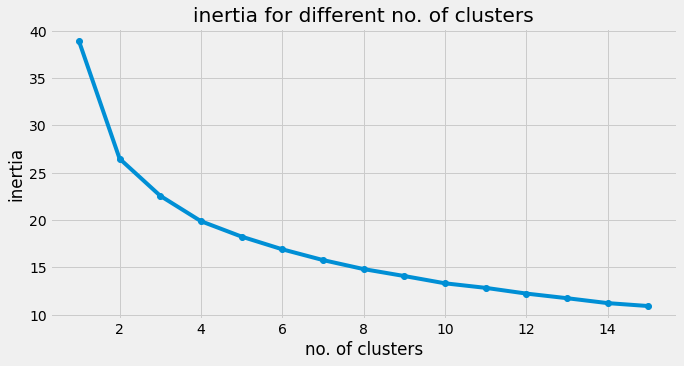

In [14]:
plot_inertia(max_abs_train)

- loss is lower when using max abs scaler for preprocessing
- max abs scaler transform data such that after clustering, data points tend to be nearer to their centriod
- can pick 4 as no. of clusters as loss seems to not decrease much after 4

In [15]:
kmean_abs = KMeans(n_clusters=4, random_state=42)
kmean_abs.fit(max_abs_train)
kmean_labels = pd.Series(kmean_abs.predict(max_abs_train), index=train.index)
kmean_abs.inertia_

19.860844529369338

- ##### K-means result Visualization and Analysis

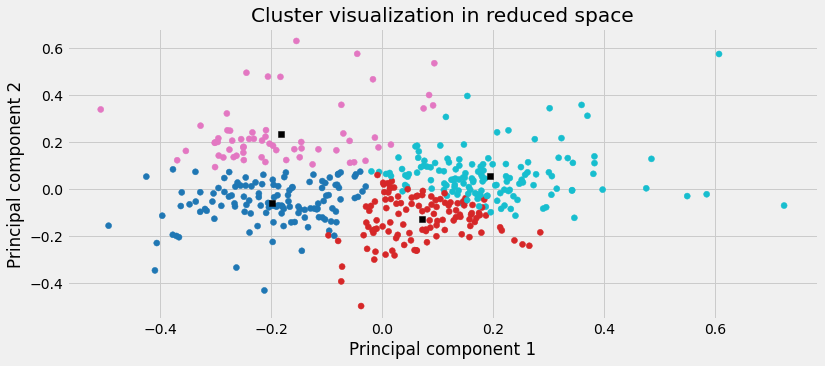

In [16]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(max_abs_train)
centers = pca.transform(kmean_abs.cluster_centers_)

plt.scatter(reduced[:,0], reduced[:,1],  c=kmean_labels, cmap='tab10')
plt.scatter(centers[:,0], centers[:,1], marker='s', c='black')

plt.title('Cluster visualization in reduced space')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

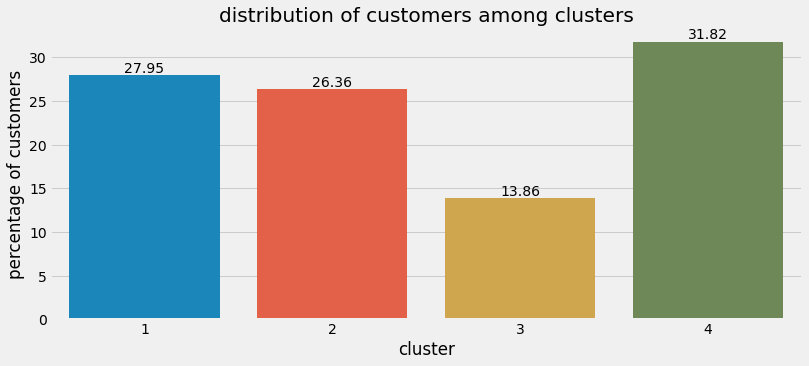

In [17]:
train['cluster'] = kmean_labels + 1
cluster_counts = np.round(train['cluster'].value_counts(normalize=True) * 100, 2)
ax = sns.barplot(x=cluster_counts.index, y=cluster_counts)
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xlabel('cluster')
ax.set_ylabel('percentage of customers')
ax.set_title('distribution of customers among clusters')
plt.show()

- fourth cluster has the largest no. of customers falling into

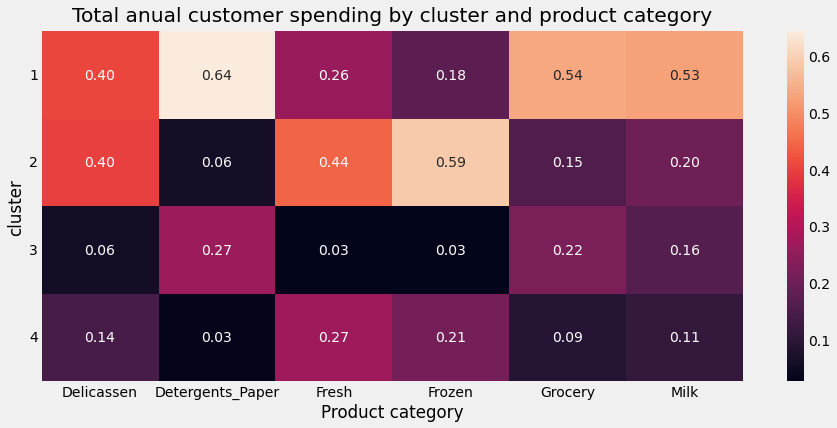

In [18]:
plt.figure(figsize=(14,6))
pivot = train.pivot_table(index='cluster', aggfunc='sum')
sum_by_cluster = pivot.sum()
sns.heatmap(pivot / sum_by_cluster, annot=True, fmt='.2f')
plt.title('Total anual customer spending by cluster and product category', pad=10)
plt.xlabel('Product category')
plt.yticks(rotation=0)
plt.show()

- most of the yearly income for product category 
    1. Delicassen come from cluster 1 and 2
    2. Detergents Paper, Grocery, Milk come from cluster 1
    3. Fresh, Frozen  come from cluster 2
- providing better offers to customers in cluster 3 and 4 could help increase revenue and maintain customer loyalty

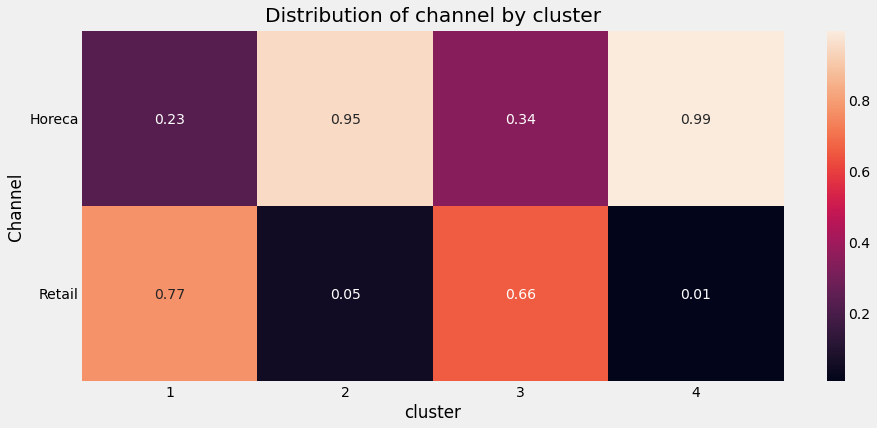

In [19]:
ctab = pd.crosstab(train['Channel'], train['cluster'])
plt.figure(figsize=(14,6))
sns.heatmap(ctab / ctab.sum(), annot=True, fmt='.2f')
plt.title('Distribution of channel by cluster', pad=10)
plt.yticks(rotation=0)
plt.show()

- more than 60 % of customers in cluster 1 and 3 are from Retail channel
- for cluster 2 and 4, majority of customers are from Horeca channel

- ##### Agglomerative Clustering


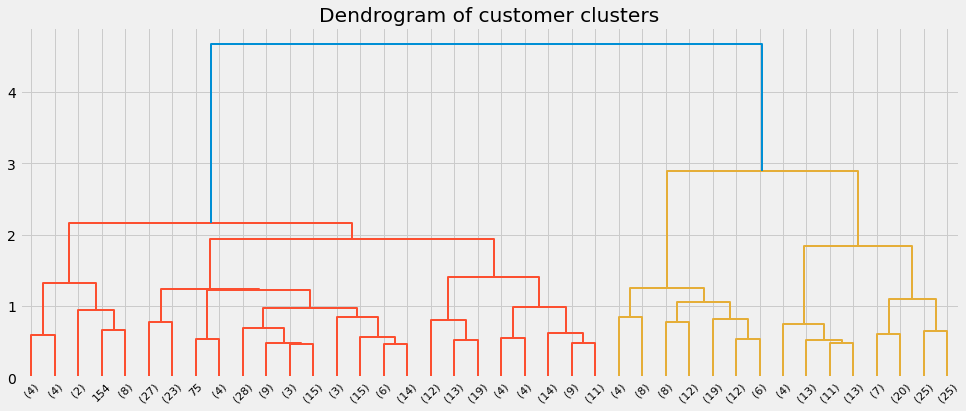

In [20]:
plt.rcParams['lines.linewidth'] = 2
plt.figure(figsize=(15, 6))
Z = linkage(max_abs_train, 'ward')
dn = dendrogram(Z, leaf_font_size=11, truncate_mode='lastp', p=40)
plt.title('Dendrogram of customer clusters')
plt.show()

- the dendogram shows 40 clusters that were lately merged i.e. 40 most dissimilar clusters
- customer index no. 154 and no. 75 spendings are distinct from others